In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson

MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
MAX_RELOC = 5
BETA_req1 = 3
BETA_req2 = 4
BETA_ret1 = 3
BETA_ret2 = 2
l = 0.9
Credit = 10
Moving_cost = 2

#### Оценка максимального значения Пуассоновского потока (приближенно)
Так как Пуассоновский поток не лимитирован сверху, перебор всех возможных вероятных событий невозможен. Оценим, как убывает вероятность событий с ростом верхней границы

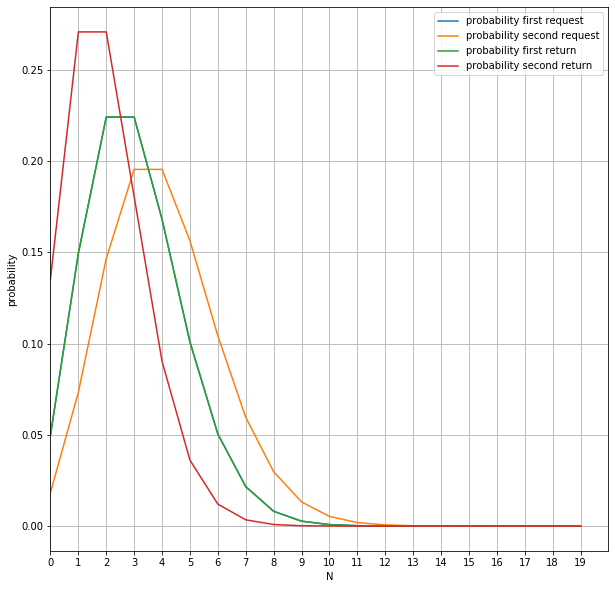

In [35]:
history = {
    'probability 1':[],
    'probability 2':[],
    'probability 3':[],
    'probability 4':[],
    'maximum':[]
}
for max_ in np.arange(0, 20):
    history['maximum'].append(max_)
    history['probability 1'].append(poisson.pmf(max_, BETA_req1))
    history['probability 2'].append(poisson.pmf(max_, BETA_req2))
    history['probability 3'].append(poisson.pmf(max_, BETA_ret1))
    history['probability 4'].append(poisson.pmf(max_, BETA_ret2))
plt.figure(figsize=(10, 10))
plt.plot(history['maximum'], history['probability 1'], label = 'probability first request')
plt.plot(history['maximum'], history['probability 2'], label = 'probability second request')
plt.plot(history['maximum'], history['probability 3'], label = 'probability first return')
plt.plot(history['maximum'], history['probability 4'], label = 'probability second return')
plt.xlim([0, 20])
plt.xticks(np.arange(0, 20))
plt.ylabel('probability')
plt.xlabel('N')
plt.legend()
plt.grid()
plt.show()

In [36]:
second_ret_threshold = 10
first_ret_threshold = 12
second_req_threshold = 15
first_req_threshold = 12

Данные ограничения позволят снизить сложность алгоритма. Оценка правдоподобия при этом будет немного смещена в меньшую сторону, но почти не существенно, т.к. при данных интенсивностях потока, крайние значения будут наблюдаться с низкой вероятностью и для обучения этого достаточно

In [39]:
poisson_values = {}
def get_poisson(n, beta):
    if (n, beta) not in poisson_values.keys():
        poisson_values[(n, beta)] = poisson.pmf(n, beta)
    return poisson_values[(n, beta)]
def expectation(state, action, state_value):
    returns = 0.0
    returns -= Moving_cost * abs(action)
    num_of_cars_first_loc = min(state[0] - action, MAX_CARS)
    num_of_cars_second_loc = min(state[1] + action, MAX_CARS)
    for first_req in np.arange(first_req_threshold):
        for second_req in np.arange(second_req_threshold):
            prob_req = get_poisson(first_req, BETA_req1) * get_poisson(second_req, BETA_req2)
            
            valid_first = min(num_of_cars_first_loc, first_req)
            valid_second = min(num_of_cars_second_loc, second_req)

            reward = (valid_first + valid_second) * Credit
            num_of_cars_first_loc -= valid_first
            num_of_cars_second_loc -= valid_second
            
            for first_ret in np.arange(first_ret_threshold):
                for second_ret in np.arange(second_ret_threshold):
                    prob_return = get_poisson(first_ret, BETA_ret1) * get_poisson(second_ret, BETA_ret2)
                    num_of_cars_first_loc_ = min(num_of_cars_first_loc + first_ret, MAX_CARS)
                    num_of_cars_second_loc_ = min(num_of_cars_second_loc + second_ret, MAX_CARS)
                    likelihood = prob_return * prob_req
                    returns += likelihood * (reward + l * state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

In [41]:
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros(value.shape, dtype=np.int)
tol = 1e-2
iterations = 0
while True:
    while True:
        old_value = value.copy()
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_state_value = expectation([i, j], policy[i, j], value)
                value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()
        if max_value_change < tol:
            break
    policy_stable = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expectation([i, j], action, value))
                else:
                    action_returns.append(-np.inf)
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            if policy_stable and old_action != new_action:
                policy_stable = False
    if policy_stable:
        break
    iterations += 1

KeyboardInterrupt: 

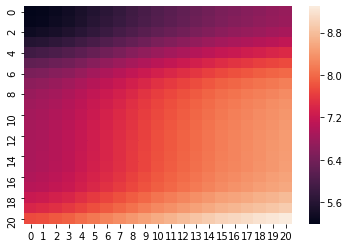

In [42]:
sns.heatmap(value)